In [2]:
# read the tsv file
import json 
import re 

regexstr = r"\/\/Sent \d{1,2}:"

file_name = "/Users/daniel/ideaProjects/allennlp/ipython/multirc/multirc-Question_phenomenta_annotations-General_phenomena.tsv"
paragraphs = []
qas = []
counter = 1
latest_paragraph = ""

info_map = {}

with open(file_name) as f:
    content = f.read().splitlines()
    for line in content: 
        counter = counter + 1
        splitted = line.split("\t")
        if len(splitted) > 3: 
            p_text = splitted[0].strip()
            q_text = splitted[1].strip()
            ans_text = [x.strip() for x in splitted[2].split("//")]
            correct_or_not = splitted[3].split(",")
            phenomenon_labels = [x.strip() for x in splitted[4].split(",")]
            
            assert len(ans_text) == len(correct_or_not), f"{ans_text} - {correct_or_not}"
            
            if len(p_text.strip()) > 10: 
                paragraphs.append({"context": latest_paragraph, "qas": qas})
                latest_paragraph = re.sub(regexstr, "", p_text).strip()
                qas = []
            elif len(q_text) > 3: 
                ans = [{"answer_start": 0, "text": latest_paragraph.split(" ")[0]}]
                # ans = [{"answer_start": 0, "text": x} for x in ans_text]
                question = {"answers": ans, "question": q_text, "id": str(counter)}
                qas.append(question)
                info_map[q_text] = (ans_text, correct_or_not, phenomenon_labels)
                    
    data = {"data": [{"paragraphs": paragraphs}]}
    
    # save data on disk 
    with open('/Users/daniel/ideaProjects/allennlp/QA_datasets/mutlirc_questions.json', 'w', newline='') as f:
        f.write(json.dumps(data))

In [3]:
def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)

    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break
    mat = numpy.array(features)

    return (mat, labels, questions, pred_ans)

In [4]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# (mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=0)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/multirc/out33-ner-test.txt", "ipython/multirc/out22-ner-test.txt", max_size=-1)

# read the questions and remember question ids:
# question_paragraph_id_map = {}
# ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/mutlirc_questions.json"
# with open(ff) as file:
#     dataset_json = json.load(file)
#     dataset = dataset_json['data']
#     for article in dataset:
#         for paragraph in article['paragraphs']:
#             for qa in paragraph['qas']:
#                 key = qa['question'] + paragraph['context']
#                 id = qa['id']
#                 print(id)
#                 question_paragraph_id_map[key] = id
# bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

multirc_reasoning_types = [info_map[x["q"]][2] for x in questions_ad]

multirc_reasoning_types, pred_ans_ad, questions_ad

len(multirc_reasoning_types), len(questions_ad), len(info_map), info_map

(65,
 65,
 76,
 {'Question': (['Options'], ['Labels '], ['Phenomena']),
  'Who does "The Octopus" terrorize?': (['Railroad magnates and other captains of industry',
    'The spider',
    'Mr. Wentworth',
    'Ram Singh',
    'Norvell Page'],
   ['1', '0', '0', '0', '0'],
   ['Coref', 'Lex', 'Common']),
  'How is octopus different from the spider?': (['Octopus is the criminalogist',
    'Octopus is villain in white',
    'The octopus is garbed completely in light weight full length costume and is only ever seen sitting in a chair while the Spider is garbed in a white costume.',
    'Octoups is poor man',
    'They dress and look differently.'],
   ['0', '1', '0', '0', '1'],
   ['Coref', 'Lex', 'Common']),
  "Who knows the spider's other identity and why?": (["Only Jackson and Ram Singh, because he doesn't trust his fiance. This is to keep his identity a secret.",
    'The police he secretly works for, and a few others, to keep his position secret.',
    'Jackson and Ram Singh, his butle

{'Cause', 'Common', 'Math', 'List', 'Lex', 'Sp-temp', 'Coref', 'Other'}
Cause -> 35.75757575757576 0
Common -> 29.238100773906403 0
Math -> 13.96825396825397 0
List -> 43.65079365079365 0
Lex -> 36.95434134383066 0
Sp-temp -> 38.46560846560847 0
Coref -> 40.472457413967476 0
Other -> 100.0 0


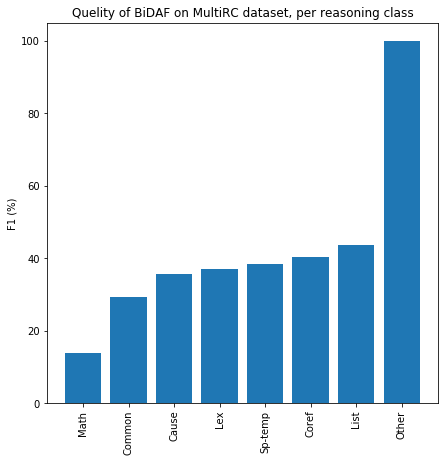

In [20]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set([y for x in multirc_reasoning_types for y in x])
print(unique_types111)

scores_zipped_labels= []
for t in unique_types111:
#     print(t)
    scores_ins = []
    # select questions which contain the reasoning type 
    for i, x  in enumerate(questions_ad): 
        question = x["q"]
        (ans_text, correct_or_not, phenomenon_labels) = info_map[question]
        if t in phenomenon_labels: # check if the target phenomena is included 
            correct_ans = [a for (a, c) in zip(ans_text,correct_or_not) if c == "1"]
            predicted_label = pred_ans_ad[i]
            max_f1 = max([f1_score(predicted_label,y) for y in correct_ans])
#             print(str(c) + " -> " + str(100.0 * max_f1))
            scores_ins.append(100.0 * max_f1)
    scores_zipped_labels.append((sum(scores_ins) / len(scores_ins), t))
    print(str(t) + " -> " + str(sum(scores_ins) / len(scores_ins)), len(scores))
# similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

# scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BiDAF on MultiRC dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [6]:
# mat_concat = np.concatenate((mat, mat_ad), axis=0)
# reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(unique_types111) # list(set(bibi_reasoning_types))
# # unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
multirc_reasoning_type_indices = [unique_reasoning_types.index(x) for coll in multirc_reasoning_types for x in coll]
# labels_concat = np.concatenate((labels, labels_ad))
# pred_concat = np.concatenate((pred_ans, pred_ans_ad))

# multirc_reasoning_type_indices
# unique_reasoning_types.index(x) 

In [7]:
from sklearn.cluster import KMeans
db = KMeans(n_clusters=len(unique_reasoning_types), random_state=2).fit(mat_ad)
# db = DBSCAN(eps=0.3, min_samples=10).fit(mat_ad)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# labelsss = db.labels_
# repeat the labels, for each category 
labelsss = []
for i, l in enumerate(db.labels_): 
    for j in range(len(multirc_reasoning_types[i])): 
        labelsss.append(l)

len(unique_reasoning_types)

8

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

print(len(multirc_reasoning_type_indices))
print(len(labelsss))
matt1 = confusion_matrix(multirc_reasoning_type_indices, labelsss) 

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


138


NameError: name 'labelsss' is not defined

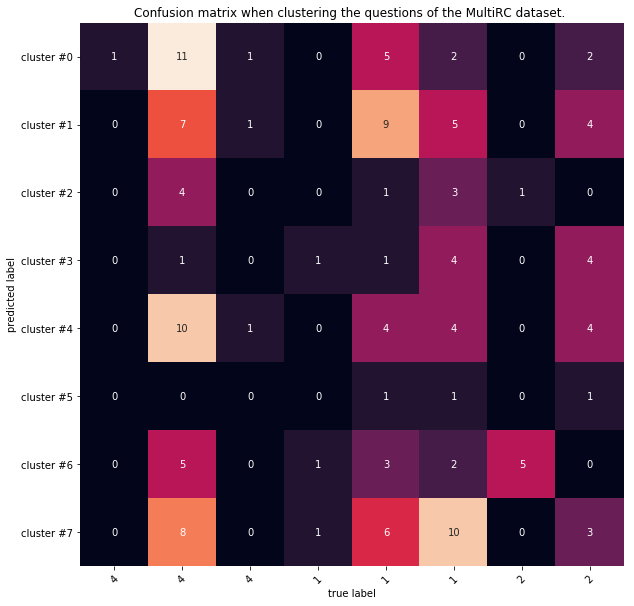

In [13]:
plt.figure(figsize=(10, 10))
sss = sns.heatmap(matt1.T, square=True,
            annot=True,
            fmt='d', cbar=False,
            xticklabels=True,
            yticklabels=True
            )

y_labels = ['cluster #' + str(i) for i in range(len(unique_reasoning_types))]
sss.set_xticklabels(labelsss, rotation=45)
sss.set_yticklabels(y_labels, rotation=0)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix when clustering the questions of the MultiRC dataset. ')
plt.show()

In [17]:
# clustering points into two groups
ss = len(unique_types111)
accuracy_table = np.zeros(shape=(ss, ss)) 
count_table = np.empty(shape=(ss, ss), dtype=object) 
unique_types111_list = list(unique_types111)
for ind1, type1 in enumerate(unique_types111_list): 
    for ind2, type2 in enumerate(unique_types111_list):
        
        count1 = 0
        count2 = 0
        
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(multirc_reasoning_types): 
            if type1 in x and type2 not in x: 
#                 labels_binary.append(1)
                points.append(mat_ad[i])
                labels.append(x)
                count1 += 1
                
            if type2 in x and type1 not in x:
#                 labels_binary.append(-1)
                points.append(mat_ad[i])
                labels.append(x)
                count2 += 1
                
#             if type1 in x or type2 in x:
#                 points.append(mat_ad[i])
#                 labels.append(x)
        
        from sklearn.cluster import KMeans
        db = KMeans(n_clusters=2, random_state=2).fit(points)
        cluster_labels = db.labels_
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        def check_if_label_is_shared(labels1, labels2): 
            label_intersection = list(set(labels1) & set(labels2))
            return (type1 in label_intersection) or (type2 in label_intersection)
            
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
#                 print(labels[ii], labels[jj], labels[ii] == labels[jj])
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and check_if_label_is_shared(labels[ii], labels[jj]): 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and check_if_label_is_shared(labels[ii], labels[jj]): 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and not check_if_label_is_shared(labels[ii], labels[jj]): 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and not check_if_label_is_shared(labels[ii], labels[jj]): 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
        
        countstr = str(f"{len(labels)}/{count1}/{count2}")
        print(countstr)
        count_table[ind1][ind2] = countstr
        count_table[ind2][ind1] = count_table[ind1][ind2] 
        
accuracy_table

type1:  Cause  type2:  Coref
same_label_same_cluster:  0.4588344125809436 992
same_label_diff_cluster:  0.45790934320074006 990
diff_label_same_cluster:  0.041628122109158186 90
diff_label_diff_cluster:  0.041628122109158186 90
---------
47/2/45
type1:  Cause  type2:  Other
same_label_same_cluster:  0.16666666666666666 2
same_label_diff_cluster:  0.3333333333333333 4
diff_label_same_cluster:  0.3333333333333333 4
diff_label_diff_cluster:  0.16666666666666666 2
---------
4/3/1
type1:  Cause  type2:  Sp-temp
same_label_same_cluster:  0.38011695906432746 130
same_label_diff_cluster:  0.42105263157894735 144
diff_label_same_cluster:  0.10526315789473684 36
diff_label_diff_cluster:  0.0935672514619883 32
---------
19/2/17
type1:  Cause  type2:  Common
same_label_same_cluster:  0.45073891625615764 366
same_label_diff_cluster:  0.4802955665024631 390
diff_label_same_cluster:  0.03201970443349754 26
diff_label_diff_cluster:  0.03694581280788178 30
---------
29/1/28
type1:  Cause  type2:  Lex
s

array([[0.        , 0.50046253, 0.33333333, 0.47368421, 0.48768473,
        0.48663102, 0.46666667, 0.77777778],
       [0.50046253, 0.        , 0.56161616, 0.49825784, 0.48780488,
        0.48648649, 0.54545455, 0.54471545],
       [0.33333333, 0.56161616, 0.        , 0.54385965, 0.48387097,
        0.48387097, 0.33333333, 0.42857143],
       [0.47368421, 0.49825784, 0.54385965, 0.        , 0.50089127,
        0.51231527, 0.57142857, 0.60869565],
       [0.48768473, 0.48780488, 0.48387097, 0.50089127, 0.        ,
        0.48      , 0.5483871 , 0.50344828],
       [0.48663102, 0.48648649, 0.48387097, 0.51231527, 0.48      ,
        0.        , 0.48275862, 0.50757576],
       [0.46666667, 0.54545455, 0.33333333, 0.57142857, 0.5483871 ,
        0.48275862, 0.        , 0.71428571],
       [0.77777778, 0.54471545, 0.42857143, 0.60869565, 0.50344828,
        0.50757576, 0.71428571, 0.        ]])

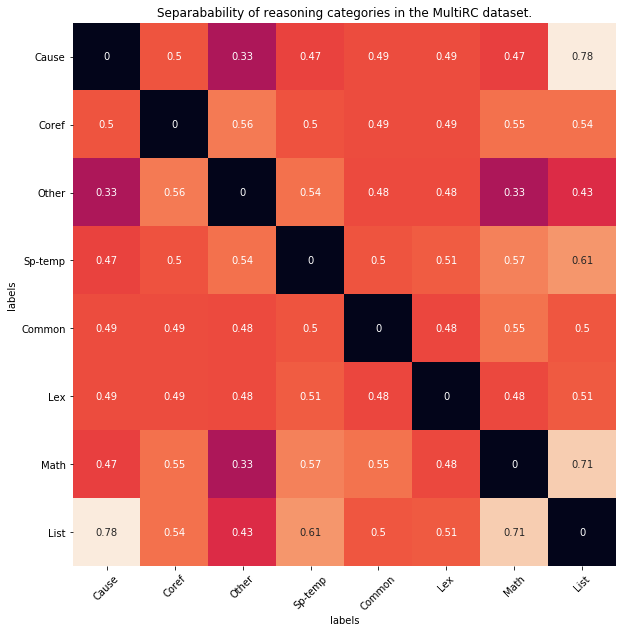

array([[0.        , 0.50046253, 0.33333333, 0.47368421, 0.48768473,
        0.48663102, 0.46666667, 0.77777778],
       [0.50046253, 0.        , 0.56161616, 0.49825784, 0.48780488,
        0.48648649, 0.54545455, 0.54471545],
       [0.33333333, 0.56161616, 0.        , 0.54385965, 0.48387097,
        0.48387097, 0.33333333, 0.42857143],
       [0.47368421, 0.49825784, 0.54385965, 0.        , 0.50089127,
        0.51231527, 0.57142857, 0.60869565],
       [0.48768473, 0.48780488, 0.48387097, 0.50089127, 0.        ,
        0.48      , 0.5483871 , 0.50344828],
       [0.48663102, 0.48648649, 0.48387097, 0.51231527, 0.48      ,
        0.        , 0.48275862, 0.50757576],
       [0.46666667, 0.54545455, 0.33333333, 0.57142857, 0.5483871 ,
        0.48275862, 0.        , 0.71428571],
       [0.77777778, 0.54471545, 0.42857143, 0.60869565, 0.50344828,
        0.50757576, 0.71428571, 0.        ]])

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111_list, rotation=45)
sss.set_yticklabels(unique_types111_list, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories in the MultiRC dataset.')
plt.show()

In [21]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in accuracy_table]))

0.0	0.5004625346901017	0.3333333333333333	0.47368421052631576	0.4876847290640394	0.48663101604278075	0.4666666666666667	0.7777777777777778
0.5004625346901017	0.0	0.5616161616161616	0.49825783972125437	0.4878048780487805	0.4864864864864865	0.5454545454545454	0.5447154471544715
0.3333333333333333	0.5616161616161616	0.0	0.543859649122807	0.4838709677419355	0.4838709677419355	0.3333333333333333	0.42857142857142855
0.47368421052631576	0.49825783972125437	0.543859649122807	0.0	0.5008912655971479	0.5123152709359606	0.5714285714285714	0.6086956521739131
0.4876847290640394	0.4878048780487805	0.4838709677419355	0.5008912655971479	0.0	0.48	0.5483870967741935	0.503448275862069
0.48663101604278075	0.4864864864864865	0.4838709677419355	0.5123152709359606	0.48	0.0	0.4827586206896552	0.5075757575757576
0.4666666666666667	0.5454545454545454	0.3333333333333333	0.5714285714285714	0.5483870967741935	0.4827586206896552	0.0	0.7142857142857143
0.7777777777777778	0.5447154471544715	0.42857142857142855	0.60869

In [19]:
count_table[count_table == None] = ""
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in count_table]))
unique_types111_list

	47/2/45	4/3/1	19/2/17	29/1/28	34/3/31	6/3/3	9/3/6
47/2/45		45/45/0	42/35/7	42/29/13	37/26/11	45/44/1	42/41/1
4/3/1	45/45/0		19/1/18	31/1/30	32/1/31	4/1/3	7/1/6
19/2/17	42/35/7	19/1/18		34/11/23	29/8/21	21/18/3	24/18/6
29/1/28	42/29/13	31/1/30	34/11/23		25/12/13	31/29/2	30/27/3
34/3/31	37/26/11	32/1/31	29/8/21	25/12/13		30/29/1	33/29/4
6/3/3	45/44/1	4/1/3	21/18/3	31/29/2	30/29/1		7/2/5
9/3/6	42/41/1	7/1/6	24/18/6	30/27/3	33/29/4	7/2/5	


['Cause', 'Coref', 'Other', 'Sp-temp', 'Common', 'Lex', 'Math', 'List']

[[0.         1.10144928 0.85714286 0.85714286 0.96774194 0.96981891
  0.85714286 1.12849162]
 [1.10144928 0.         1.08950086 1.09771689 1.12401353 1.12709832
  1.09872029 1.08939709]
 [0.85714286 1.08950086 0.         1.11111111 0.96774194 0.97142857
  1.33333333 1.11578947]
 [0.85714286 1.09771689 1.11111111 0.         0.97211155 1.19449902
  1.5        1.18181818]
 [0.96774194 1.12401353 0.96774194 0.97211155 0.         1.18113612
  0.99421965 1.20225989]
 [0.96981891 1.12709832 0.97142857 1.19449902 1.18113612 0.
  1.03739837 1.12550607]
 [0.85714286 1.09872029 1.33333333 1.5        0.99421965 1.03739837
  0.         1.1       ]
 [1.12849162 1.08939709 1.11578947 1.18181818 1.20225989 1.12550607
  1.1        0.        ]]


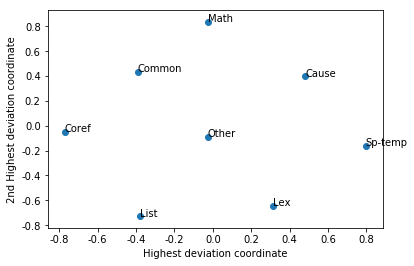

In [43]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()

In [20]:
# Binary classification of points into two groups
from sklearn.linear_model import LogisticRegression
ss = len(unique_types111)
accuracy_table = np.zeros(shape=(ss, ss)) 


for ind1, type1 in enumerate(unique_types111): 
    for ind2, type2 in enumerate(unique_types111):
                
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        labels_binary = []
        for i, x in enumerate(multirc_reasoning_types): 
#             print(x)
            if type1 in x or type2 in x:
                
                if type1 in x and type2 not in x: 
                    labels_binary.append(1)
                    points.append(mat_ad[i])
                    labels.append(x)
                
                if type2 in x and type1 not in x:
                    labels_binary.append(-1)
                    points.append(mat_ad[i])
                    labels.append(x)
        
        # from sklearn.cluster import KMeans
        # db = KMeans(n_clusters=2, random_state=2).fit(points)
        # cluster_labels = db.labels_
        # clf = SVC()
        clf = LogisticRegression()
        print("points: ", len(points))
        print("labels: ", len(labels))
        clf.fit(points, labels_binary) 
        print("labels: ", labels)
        cluster_labels = clf.predict(points)
        print("cluster_labels: ", len(cluster_labels))
        print(cluster_labels)
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        def check_if_label_is_shared(labels1, labels2): 
            label_intersection = list(set(labels1) & set(labels2))
            return (type1 in label_intersection) or (type2 in label_intersection)
            
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
#                 print(labels[ii], labels[jj], labels[ii] == labels[jj])
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and check_if_label_is_shared(labels[ii], labels[jj]): 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and check_if_label_is_shared(labels[ii], labels[jj]): 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and not check_if_label_is_shared(labels[ii], labels[jj]): 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and not check_if_label_is_shared(labels[ii], labels[jj]): 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
accuracy_table


type1:  List  type2:  Lex
points:  33
labels:  33
labels:  [['Coref', 'Lex', 'Common'], ['Coref', 'Lex', 'Common'], ['Coref', 'Lex', 'Common'], ['Coref', 'Lex', 'Common'], ['Lex', 'Coref', 'Sp-temp'], ['Coref', 'Lex', 'Common', 'Sp-temp'], ['Coref', 'Lex'], ['Coref', 'Lex'], ['Coref', 'Lex', 'Sp-temp'], ['Sp-temp', 'Lex'], ['Common', 'Lex'], ['Coref', 'Math', 'Lex'], ['Coref', 'Lex'], ['Sp-temp', 'Lex'], ['Sp-temp', 'Lex', 'Common', 'Coref'], ['Sp-temp', 'Coref', 'Lex'], ['Sp-temp', 'Lex', 'Common'], ['Coref', 'Lex'], ['Common', 'Sp-temp', 'Lex'], ['Lex', 'Common', 'Math'], ['Common', 'Lex'], ['Lex', 'Common'], ['Lex', 'Common'], ['Sp-temp', 'Common', 'Coref', 'Lex'], ['Common', 'Lex'], ['Coref', 'Common', 'List'], ['Coref', 'Common', 'Lex'], ['Coref', 'Lex'], ['Coref', 'Math', 'List'], ['Coref', 'List', 'Common'], ['Lex', 'Common'], ['Lex', 'Coref', 'Common'], ['List', 'Common']]
cluster_labels:  33
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  1 -1 -1 

labels:  [['Coref', 'Lex', 'Common'], ['Coref', 'Lex', 'Common'], ['Coref', 'Common'], ['Coref', 'Lex', 'Common'], ['Coref', 'Lex', 'Common'], ['Common'], ['Coref', 'Lex', 'Common', 'Sp-temp'], ['Common', 'Lex'], ['Sp-temp', 'Lex', 'Common', 'Coref'], ['Sp-temp', 'Lex', 'Common'], ['Coref', 'Common'], ['Common', 'Sp-temp', 'Lex'], ['Lex', 'Common', 'Math'], ['Common', 'Lex'], ['Lex', 'Common'], ['Lex', 'Common'], ['Sp-temp', 'Common', 'Coref', 'Lex'], ['Cause'], ['Common', 'Lex'], ['Coref', 'Common'], ['Coref', 'Sp-temp', 'Common'], ['Coref', 'Common'], ['Common'], ['Coref', 'Common', 'List'], ['Coref', 'Common', 'Lex'], ['Coref', 'List', 'Common'], ['Lex', 'Common'], ['Lex', 'Coref', 'Common'], ['List', 'Common']]
cluster_labels:  29
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1]
same_label_same_cluster:  0.9310344827586207 756
same_label_diff_cluster:  0.0 0
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.06896551724137931 56
---

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1

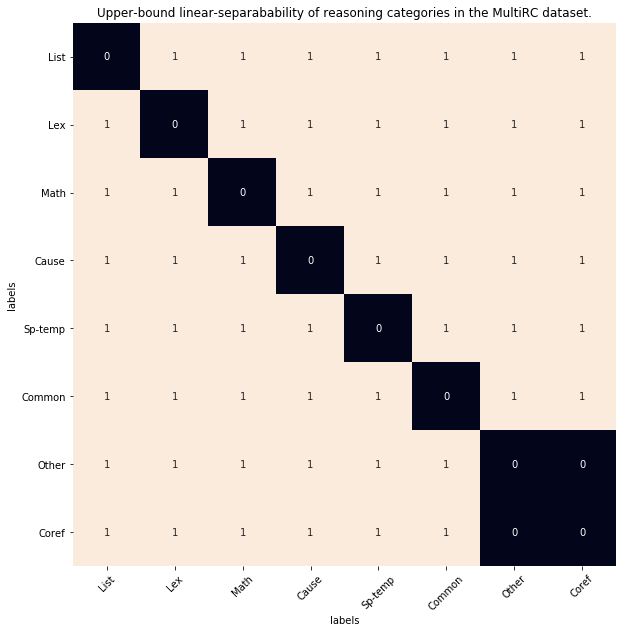

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111, rotation=45)
sss.set_yticklabels(unique_types111, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Upper-bound linear-separabability of reasoning categories in the MultiRC dataset.')
plt.show()

[[0.         1.80504202 1.85714286 2.         2.         1.69318182
  2.         1.62072155]
 [1.80504202 0.         1.99193548 2.         1.78407557 1.52159468
  2.         1.34837093]
 [1.85714286 1.99193548 0.         2.         2.         1.88306452
  2.         1.83718779]
 [2.         2.         2.         0.         1.82105263 1.75913978
  2.         1.92021277]
 [2.         1.78407557 2.         1.82105263 0.         1.60731707
  2.         1.44121916]
 [1.69318182 1.52159468 1.88306452 1.75913978 1.60731707 0.
  2.         1.42372881]
 [2.         2.         2.         2.         2.         2.
  0.         1.91304348]
 [1.62072155 1.34837093 1.83718779 1.92021277 1.44121916 1.42372881
  1.91304348 0.        ]]


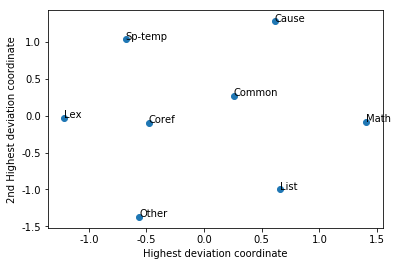

In [18]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()

In [30]:
from sklearn.neural_network import MLPClassifier

# training a single classifier on the data 
from sklearn.linear_model import LogisticRegression
import numpy 

ss = len(unique_reasoning_types)
accuracy_table = np.zeros(shape=(ss, ss)) 


from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
multirc_reasoning_types_binarized = mlb.fit_transform(multirc_reasoning_types)
mlb.classes_

# print(len(multirc_reasoning_types))
# print(len(mat_ad))

mlp = MLPClassifier(hidden_layer_sizes=(), alpha=10)
mlp.fit(mat_ad,multirc_reasoning_types_binarized)


/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [59]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score    
    
predictions = mlp.predict(mat_ad)

for i, class_ in enumerate(mlb.classes_): 
    predictions_per_class = [x[i] for x in predictions]
    gold_per_class = [x[i] for x in multirc_reasoning_types_binarized]
    f1_ = f1_score(gold_per_class, predictions_per_class) 
    size_ = sum(gold_per_class)
    print(f"Class: {class_} \t count: {size_} \t F1: {f1_}")
    

Class: Cause 	 count: 3 	 F1: 0.8
Class: Common 	 count: 30 	 F1: 0.983050847457627
Class: Coref 	 count: 46 	 F1: 1.0
Class: Lex 	 count: 31 	 F1: 1.0
Class: List 	 count: 6 	 F1: 1.0
Class: Math 	 count: 3 	 F1: 0.8
Class: Other 	 count: 1 	 F1: 1.0
Class: Sp-temp 	 count: 18 	 F1: 0.9714285714285714


In [17]:
# train a single classifier, which gets two input vectors and tell us whether the they share a class or not. 
import random 

# first, create the input data. 
assert len(mat_ad) == len(multirc_reasoning_types)

input_mat = []
output_vals = []

def are_disjoint(a, b): 
    return set(a).isdisjoint(b)

for i, x1 in enumerate(mat_ad): 
    print(f"adding instances: {100.0 * i / len(mat_ad)}")
    for j, x2 in enumerate(mat_ad): 
        if i == j: 
            continue 
            
        if are_disjoint(multirc_reasoning_types[i], multirc_reasoning_types[j]): 
            output_vals.append(1)
            input_mat.append(mat_ad[i] + mat_ad[j])
        else:
            if random.uniform(0, 1) >= 0.25: 
                continue 
            input_mat.append(mat_ad[i] + mat_ad[j])
            output_vals.append(0)
            

adding instances: 0.0
adding instances: 1.5384615384615385
adding instances: 3.076923076923077
adding instances: 4.615384615384615
adding instances: 6.153846153846154
adding instances: 7.6923076923076925
adding instances: 9.23076923076923
adding instances: 10.76923076923077
adding instances: 12.307692307692308
adding instances: 13.846153846153847
adding instances: 15.384615384615385
adding instances: 16.923076923076923
adding instances: 18.46153846153846
adding instances: 20.0
adding instances: 21.53846153846154
adding instances: 23.076923076923077
adding instances: 24.615384615384617
adding instances: 26.153846153846153
adding instances: 27.692307692307693
adding instances: 29.23076923076923
adding instances: 30.76923076923077
adding instances: 32.30769230769231
adding instances: 33.84615384615385
adding instances: 35.38461538461539
adding instances: 36.92307692307692
adding instances: 38.46153846153846
adding instances: 40.0
adding instances: 41.53846153846154
adding instances: 43.07

In [18]:
# make sure the dataset selection is balanced 
sum(output_vals), len(output_vals)

(1036, 1823)

In [25]:
# train the classifier 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(input_mat, output_vals) 

sum(output_vals)

1036

In [40]:
ss = len(unique_types111)
separation_table = np.zeros(shape=(ss, ss)) 
unique_types111_list = list(unique_types111)
for ind1, type1 in enumerate(unique_types111_list): 
    for ind2, type2 in enumerate(unique_types111_list):
        
        # we want different types 
        if type1 == type2: #  or ind2 <= ind1  
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 

        y_true = []
        input_vecs = []
        for i, x in enumerate(multirc_reasoning_types): 
            for j, y in enumerate(multirc_reasoning_types): 
                if type1 in x and type2 in y: 
                    input_vecs.append(mat_ad[i] + mat_ad[j]) 
                    if are_disjoint(x, y): 
                        y_true.append(1)
                    else: 
                        y_true.append(0)
                
        y_pred = list(clf.predict(input_vecs))
        
        assert(len(y_pred) == len(y_true))
#         print(y_pred)
#         print(y_true)
    
        from sklearn.metrics import f1_score
        separation_table[ind1][ind2] = f1_score(y_true, y_pred)
        print(separation_table[ind1][ind2])
    

type1:  Cause  type2:  Common
0.7272727272727273
type1:  Cause  type2:  Math
0.9090909090909091
type1:  Cause  type2:  List
0.8571428571428571
type1:  Cause  type2:  Lex
0.9072164948453608
type1:  Cause  type2:  Sp-temp
0.9491525423728813
type1:  Cause  type2:  Coref
0.9548387096774192
type1:  Cause  type2:  Other
1.0
type1:  Common  type2:  Cause
0.7272727272727273
type1:  Common  type2:  Math
0.6363636363636364
type1:  Common  type2:  List
0.5
type1:  Common  type2:  Lex
0.392156862745098
type1:  Common  type2:  Sp-temp
0.7868852459016393
type1:  Common  type2:  Coref
0.9330985915492958
type1:  Common  type2:  Other
1.0
type1:  Math  type2:  Cause
0.9090909090909091
type1:  Math  type2:  Common
0.6363636363636364
type1:  Math  type2:  List
0.4
type1:  Math  type2:  Lex
0.5806451612903225
type1:  Math  type2:  Sp-temp
0.823529411764706
type1:  Math  type2:  Coref
0.7804878048780487
type1:  Math  type2:  Other
1.0
type1:  List  type2:  Cause
0.8571428571428571
type1:  List  type2:  Com

/Users/daniel/.virtualenvs/bidaf_allennlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


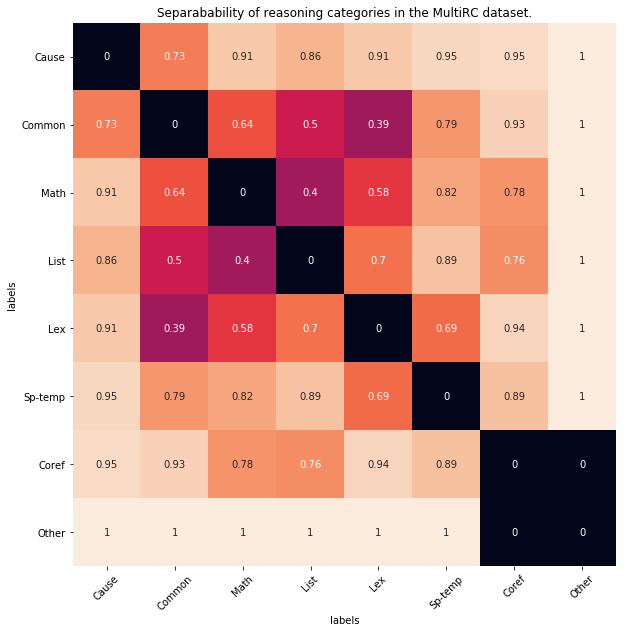

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(separation_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111_list, rotation=45)
sss.set_yticklabels(unique_types111_list, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Separabability of reasoning categories in the MultiRC dataset.')
plt.show()

In [44]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in separation_table]))
print(unique_types111_list)

0.0	0.7272727272727273	0.9090909090909091	0.8571428571428571	0.9072164948453608	0.9491525423728813	0.9548387096774192	1.0
0.7272727272727273	0.0	0.6363636363636364	0.5	0.392156862745098	0.7868852459016393	0.9330985915492958	1.0
0.9090909090909091	0.6363636363636364	0.0	0.4	0.5806451612903225	0.823529411764706	0.7804878048780487	1.0
0.8571428571428571	0.5	0.4	0.0	0.7017543859649122	0.8923076923076922	0.7647058823529412	1.0
0.9072164948453608	0.392156862745098	0.5806451612903225	0.7017543859649122	0.0	0.6890756302521007	0.9405684754521964	1.0
0.9491525423728813	0.7868852459016393	0.823529411764706	0.8923076923076922	0.6890756302521007	0.0	0.8888888888888888	1.0
0.9548387096774192	0.9330985915492958	0.7804878048780487	0.7647058823529412	0.9405684754521964	0.8888888888888888	0.0	0.0
1.0	1.0	1.0	1.0	1.0	1.0	0.0	0.0
['Cause', 'Common', 'Math', 'List', 'Lex', 'Sp-temp', 'Coref', 'Other']


[[0.         0.72727273 0.90909091 0.85714286 0.90721649 0.94915254
  0.95483871 1.        ]
 [0.72727273 0.         0.63636364 0.5        0.39215686 0.78688525
  0.93309859 1.        ]
 [0.90909091 0.63636364 0.         0.4        0.58064516 0.82352941
  0.7804878  1.        ]
 [0.85714286 0.5        0.4        0.         0.70175439 0.89230769
  0.76470588 1.        ]
 [0.90721649 0.39215686 0.58064516 0.70175439 0.         0.68907563
  0.94056848 1.        ]
 [0.94915254 0.78688525 0.82352941 0.89230769 0.68907563 0.
  0.88888889 1.        ]
 [0.95483871 0.93309859 0.7804878  0.76470588 0.94056848 0.88888889
  0.         1.76470588]
 [1.         1.         1.         1.         1.         1.
  1.76470588 0.        ]]


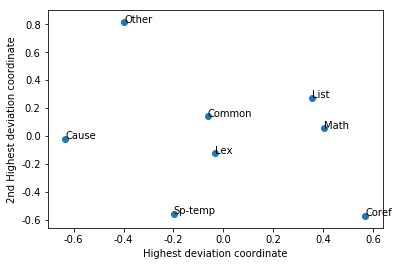

In [45]:
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
# distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(separation_table)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()